In [2]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from pathlib import Path

In [3]:
A_DPATH = Path('/gws/nopw/j04/iecdt/computer-vision-data/cam_a/imgs/../rectified_imgs')
B_DPATH = Path('/gws/nopw/j04/iecdt/computer-vision-data/cam_b/imgs/../rectified_imgs')

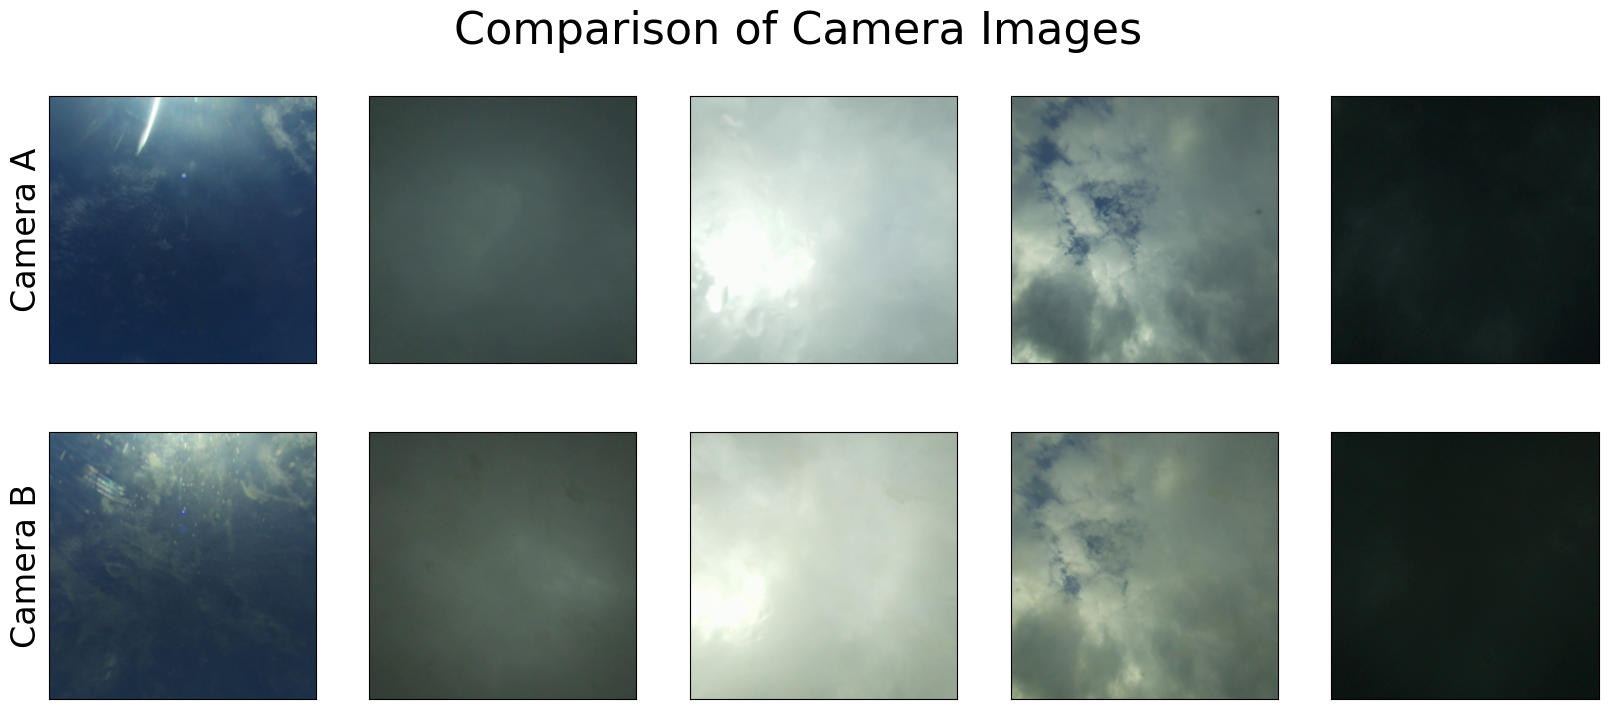

In [6]:
#Plot some matched examples from the rectified images with camera A on top and camera B on the bottom
fig, ax = plt.subplots(2, 5, figsize=(20, 8))
for axs in ax.flatten():
    axs.set_xticks([])
    axs.set_yticks([])
for i in range(5):
    n = np.random.randint(0,13760)
    ax[0,i].imshow(cv2.rotate(plt.imread(list((A_DPATH).glob('*.png'))[n]), cv2.ROTATE_90_CLOCKWISE))
    ax[1,i].imshow(cv2.rotate(plt.imread(list((B_DPATH).glob('*.png'))[n]), cv2.ROTATE_90_CLOCKWISE))

fig.suptitle("Comparison of Camera Images", fontsize=32)

row_titles = ["Camera A", "Camera B"]
for i, row in enumerate(ax):
    row[0].set_ylabel(row_titles[i], fontsize=24)



1264 -16
1264.0 580.5918
1264 -16
1264.0 580.5918
1264 -16
1264.0 580.5918
1264 -16
1264.0 580.5918
1264 -16
1264.0 580.5918


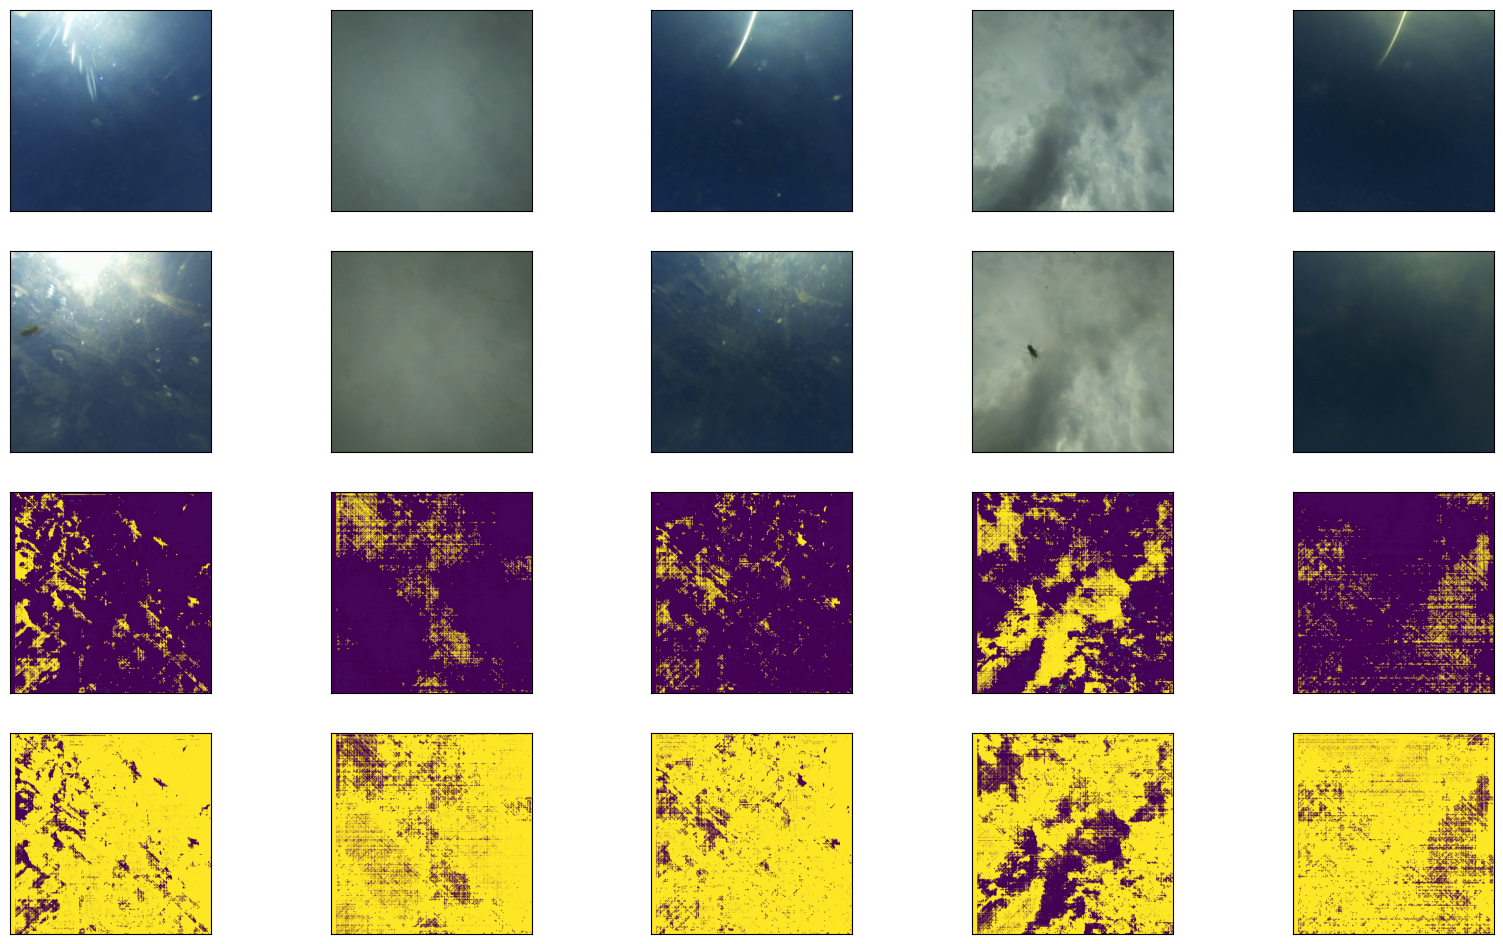

In [13]:
num_disparities = 16*10


# Camera parameters (from calibration)
focal_length = 2708  # Adjust based on your camera calibration
baseline = 271  # Distance between the cameras in meters


fig, ax = plt.subplots(4, 5, figsize=(20, 12))
for axs in ax.flatten():
    axs.set_xticks([])
    axs.set_yticks([])
for i in range(5):
    n = np.random.randint(0,13760)
    

    # Load stereo images (left and right)
    img_left = cv2.imread(list((A_DPATH).glob('*.png'))[n], cv2.IMREAD_COLOR)
    img_right = cv2.imread(list((B_DPATH).glob('*.png'))[n], cv2.IMREAD_COLOR)

    img_left = cv2.rotate(img_left, cv2.ROTATE_90_CLOCKWISE)
    img_right = cv2.rotate(img_right, cv2.ROTATE_90_CLOCKWISE)


    image_left_rgb = cv2.cvtColor(img_left, cv2.COLOR_BGR2RGB)
    image_right_rgb = cv2.cvtColor(img_right, cv2.COLOR_BGR2RGB)

    ax[0,i].imshow(image_left_rgb)
    ax[1,i].imshow(image_right_rgb)

    # Create SGM matcher
    sgm = cv2.StereoSGBM_create(
        minDisparity=0,
        numDisparities=16*5,  # Should be a multiple of 16
        blockSize=5,
        P1=8 * 3 * 5**2,  # 8 * number_of_channels * blockSize^2
        P2=32 * 3 * 5**2,
        disp12MaxDiff=1,
        uniquenessRatio=15,
        speckleWindowSize=100,
        speckleRange=32
    )

    # Compute disparity map
    disparity = sgm.compute(img_left, img_right)

    # Normalize and display
    disparity_norm = cv2.normalize(disparity, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
    disparity_vis = np.uint8(disparity_norm)

    ax[2,i].imshow(disparity_vis)

    print(disparity.max(), disparity.min())


    # Disparity is set to float
    disparity = disparity.astype(np.float32)

    # Avoid division by zero
    disparity[disparity <= 0] = 1e-6  # Prevent infinite depth

    depth_map = (focal_length * baseline) / disparity

    print(disparity.max(), depth_map.min())

    # Display depth map
    depth_vis = cv2.normalize(depth_map, None, 0, 255, cv2.NORM_MINMAX)
    depth_vis = np.uint8(depth_vis)

    ax[3,i].imshow(depth_vis)

#cv2.waitKey(0)
#cv2.destroyAllWindows()

(array([2.28000e+02, 1.51000e+02, 1.79000e+02, 3.67000e+02, 2.65000e+02,
        3.78000e+02, 2.79000e+02, 1.41000e+02, 1.19000e+02, 9.30000e+01,
        9.30000e+01, 1.77000e+02, 1.87000e+02, 5.40000e+01, 8.80000e+01,
        1.66000e+02, 7.90000e+01, 5.20000e+01, 5.50000e+01, 4.50000e+01,
        6.20000e+01, 8.60000e+01, 5.90000e+01, 9.40000e+01, 3.10000e+01,
        6.00000e+00, 7.00000e+00, 5.70000e+01, 6.60000e+01, 8.50000e+01,
        2.34000e+02, 4.90000e+01, 4.30000e+01, 2.60000e+01, 4.70000e+01,
        1.40000e+01, 1.04000e+02, 6.90000e+01, 3.20000e+01, 1.02000e+02,
        4.90000e+01, 5.40000e+01, 1.55000e+02, 4.30000e+01, 2.50000e+01,
        2.50000e+01, 4.30000e+01, 1.27000e+02, 6.10000e+01, 1.09000e+02,
        1.04000e+02, 1.62000e+02, 1.99000e+02, 3.87000e+02, 1.80000e+02,
        2.43000e+02, 4.26000e+02, 4.51000e+02, 5.23000e+02, 4.07000e+02,
        2.39000e+02, 1.66000e+02, 5.53000e+02, 7.70000e+02, 2.61000e+02,
        6.76000e+02, 8.01000e+02, 4.32000e+02, 5.28

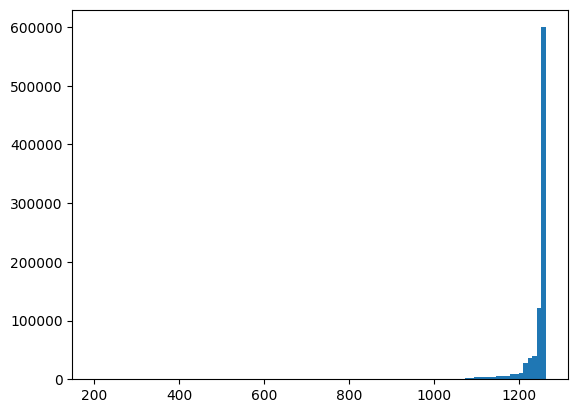

In [14]:
h = disparity[disparity > 200]

plt.hist(h.flatten(), bins=100)

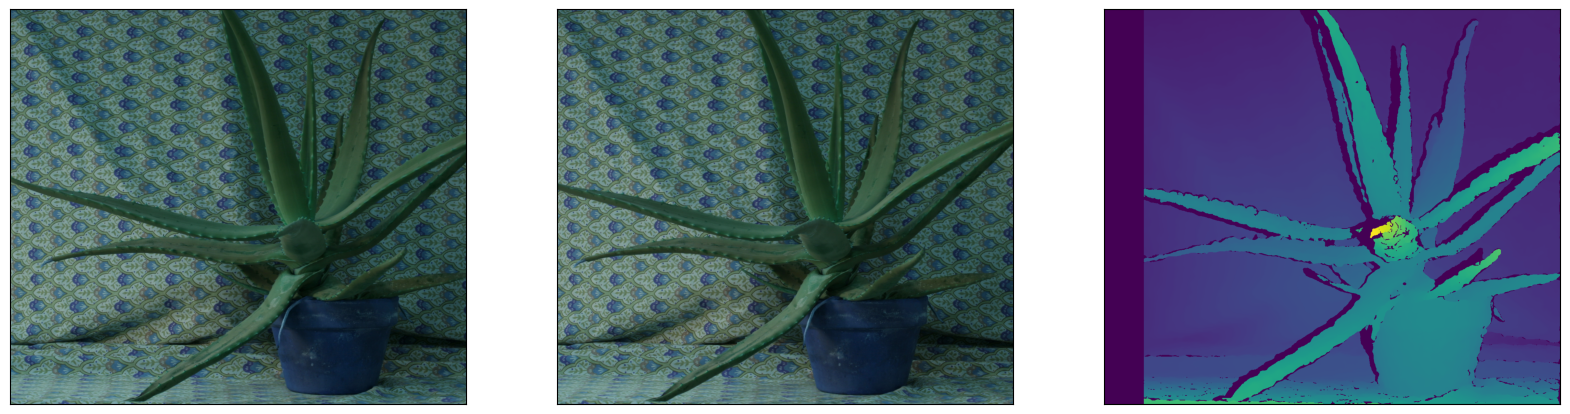

In [8]:

fig, ax = plt.subplots(1, 3, figsize=(20, 6))
for axs in ax.flatten():
    axs.set_xticks([])
    axs.set_yticks([])

imgL = cv2.imread('Aloe1.png', cv2.IMREAD_COLOR)
imgR = cv2.imread('Aloe2.png', cv2.IMREAD_COLOR)

ax[0].imshow(imgL)
ax[1].imshow(imgR)

num_disparities = 16*10

# Camera parameters (from calibration)
focal_length = 2708  # Adjust based on your camera calibration
baseline = 271  # Distance between the cameras in meters


# Load stereo images (left and right)
image_left_rgb = cv2.cvtColor(imgL, cv2.COLOR_BGR2RGB)
image_right_rgb = cv2.cvtColor(imgR, cv2.COLOR_BGR2RGB)

# Create SGM matcher
sgm = cv2.StereoSGBM_create(
    minDisparity=16,
    numDisparities=16*6,  # Should be a multiple of 16
    blockSize=16,
    P1=216,  # 8 * number_of_channels * blockSize^2
    P2=864,
    disp12MaxDiff=1,
    uniquenessRatio=10,
    speckleWindowSize=100,
    speckleRange=32
)

disparity = sgm.compute(imgL, imgR)

disparity_norm = cv2.normalize(disparity, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
disparity_vis = np.uint8(disparity_norm)

ax[2].imshow(disparity_vis)
